In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize # type: ignore
import re,string,unicodedata
from tensorflow.keras.preprocessing import text, sequence # type: ignore
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet

In [49]:
df = pd.read_csv('amazon_reviews.csv')
df = df.sample(30000)
df.head()

,Unnamed: 0,Text,Score
400131,400131,I was looking forward to a new cold cappuccino...,2
415007,415007,i was hoping to have a good outcome with these...,1
215362,215362,This tea is my go to tea for everyday! It is ...,5
234310,234310,"I've tried them all, and this brownie is great...",5
554915,554915,I like this k cup storage because i can see my...,5


In [50]:
df.shape

(30000, 3)

In [51]:
df.columns

Index(['Unnamed: 0', 'Text', 'Score'], dtype='object')

In [52]:
df.drop(columns='Unnamed: 0', inplace=True)

In [53]:
df.head()

,Text,Score
400131,I was looking forward to a new cold cappuccino...,2
415007,i was hoping to have a good outcome with these...,1
215362,This tea is my go to tea for everyday! It is ...,5
234310,"I've tried them all, and this brownie is great...",5
554915,I like this k cup storage because i can see my...,5


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 400131 to 73974
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    30000 non-null  object
 1   Score   30000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 703.1+ KB


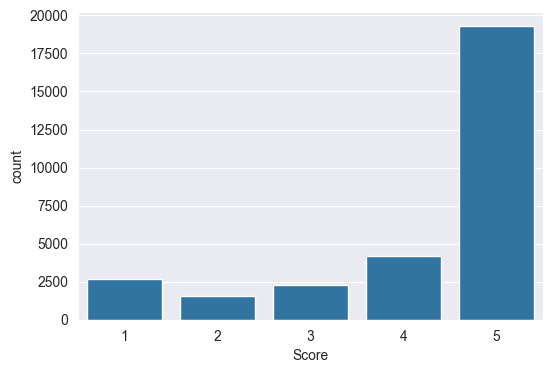

In [55]:
plt.figure(figsize=(6, 4))
sns.set_style("darkgrid")
sns.countplot(x=df.Score, data=df)
plt.show()

## Cleaning Corpus

In [56]:
def clean_text(text):
    text = str(text).lower() ## Make text lowercase
    text = re.sub('\[.*?\]', '', text) ## remove any sequence of characters in square brackets
    text = re.sub('https?://\S+|www\.\S+', '', text) ## remove links
    text = re.sub('<.*?>+', '', text) ## remove HTML tags
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) ## remove punctuation
    text = re.sub('\n', '', text) ## remove newline characters 
    text = re.sub('\w*\d\w*', '', text) ## remove words containing numbers
    return text

In [57]:
df['text_clean'] = df['Text'].apply(clean_text)

In [58]:
df.head()

,Text,Score,text_clean
400131,I was looking forward to a new cold cappuccino...,2,i was looking forward to a new cold cappuccino...
415007,i was hoping to have a good outcome with these...,1,i was hoping to have a good outcome with these...
215362,This tea is my go to tea for everyday! It is ...,5,this tea is my go to tea for everyday it is n...
234310,"I've tried them all, and this brownie is great...",5,ive tried them all and this brownie is great f...
554915,I like this k cup storage because i can see my...,5,i like this k cup storage because i can see my...


In [59]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Anubhav
[nltk_data]     Prasad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [60]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
df['text_clean'] = df['text_clean'].apply(remove_stopwords)
df.head()

,Text,Score,text_clean
400131,I was looking forward to a new cold cappuccino...,2,looking forward new cold cappuccino drink disa...
415007,i was hoping to have a good outcome with these...,1,hoping good outcome cookies considering websit...
215362,This tea is my go to tea for everyday! It is ...,5,tea go tea everyday nearly indestructible iv...
234310,"I've tried them all, and this brownie is great...",5,ive tried brownie great trail delicious brown...
554915,I like this k cup storage because i can see my...,5,like k cup storage see k cups glance instead turn


In [61]:
df = df.drop('Text', axis=1)
df = df.rename(columns={'text_clean': 'text'})
df.head()

,Score,text
400131,2,looking forward new cold cappuccino drink disa...
415007,1,hoping good outcome cookies considering websit...
215362,5,tea go tea everyday nearly indestructible iv...
234310,5,ive tried brownie great trail delicious brown...
554915,5,like k cup storage see k cups glance instead turn


## Wordcloud

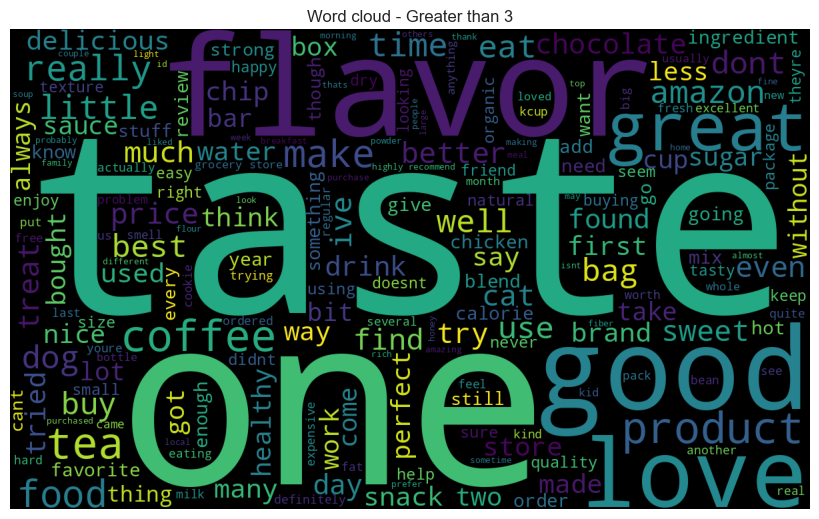

In [62]:
dfs = df.sample(1000)
wrds=''
for msg in dfs[dfs['Score']>3]['text']:
    msg=msg.split()
    for words in msg:
        wrds = wrds+words+' '
        
wcloud = WordCloud(width=1200, height=720,random_state=101).generate(wrds)

plt.figure( figsize=(10,5), facecolor='w')
plt.imshow(wcloud)
plt.title('Word cloud - Greater than 3')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

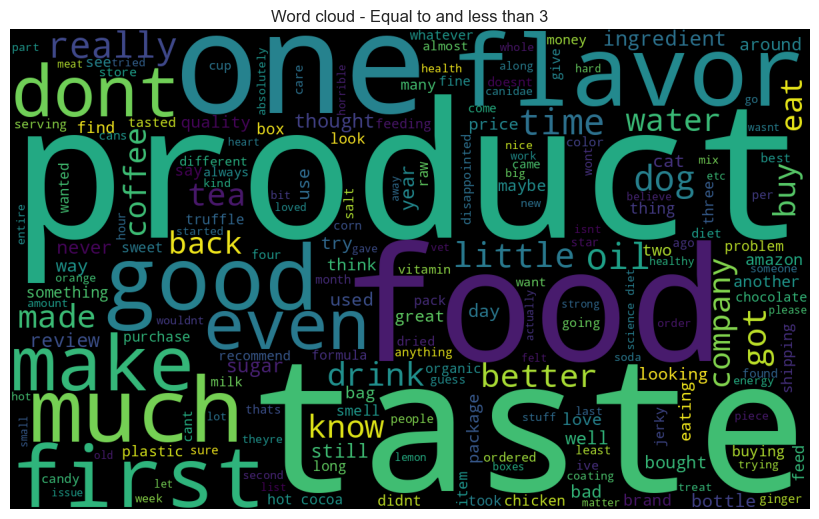

In [63]:
wrds=''
for msg in dfs[dfs['Score']<=2]['text']:
    msg=msg.split()
    for words in msg:
        wrds = wrds+words+' '
        
wcloud = WordCloud(width=1200, height=720,random_state=101).generate(wrds)

plt.figure( figsize=(10,5), facecolor='w')
plt.imshow(wcloud)
plt.title('Word cloud - Equal to and less than 3')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### Number of words in each document

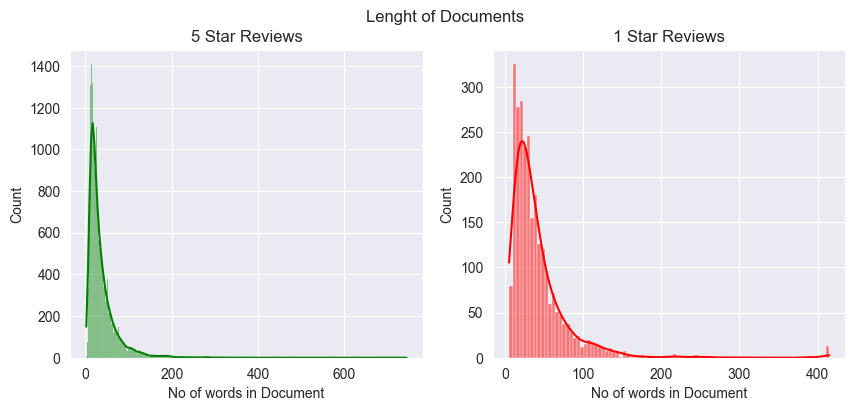

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Distribution plot for 5 Star Reviews
text_len_positive = df[df['Score'] == 5]['text'].str.split().map(lambda x: len(x))
sns.histplot(text_len_positive, kde=True, color='green', ax=ax1)
ax1.set_title('5 Star Reviews')
ax1.set_xlabel('No of words in Document')

# Distribution plot for 1 Star Reviews
text_len_negative = df[df['Score'] == 1]['text'].str.split().map(lambda x: len(x))
sns.histplot(text_len_negative, kde=True, color='red', ax=ax2)
ax2.set_title('1 Star Reviews')
ax2.set_xlabel('No of words in Document')

fig.suptitle('Lenght of Documents')
plt.show()

In [65]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

### Unigram Analysis

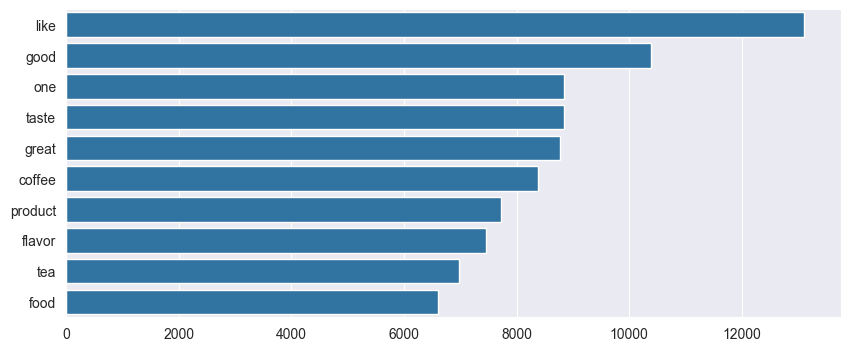

In [66]:
plt.figure(figsize = (10,4))
most_common_uni = get_top_text_ngrams(df.text,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))
plt.show()

### Bigram Analysis

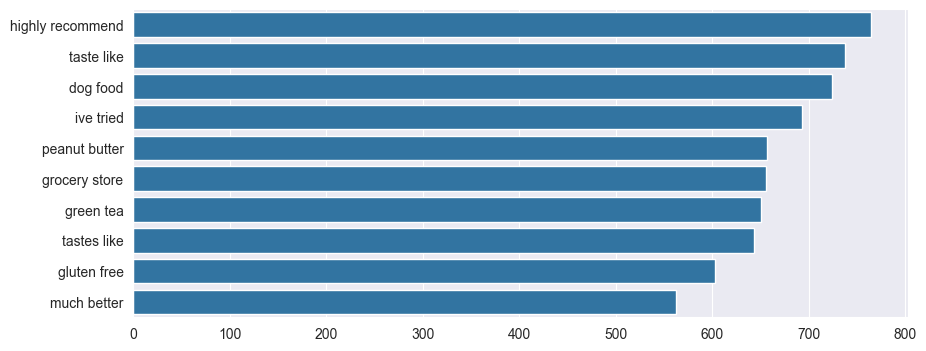

In [67]:
plt.figure(figsize = (10,4))
most_common_bi = get_top_text_ngrams(df.text,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))
plt.show()

### Trigram Analysis

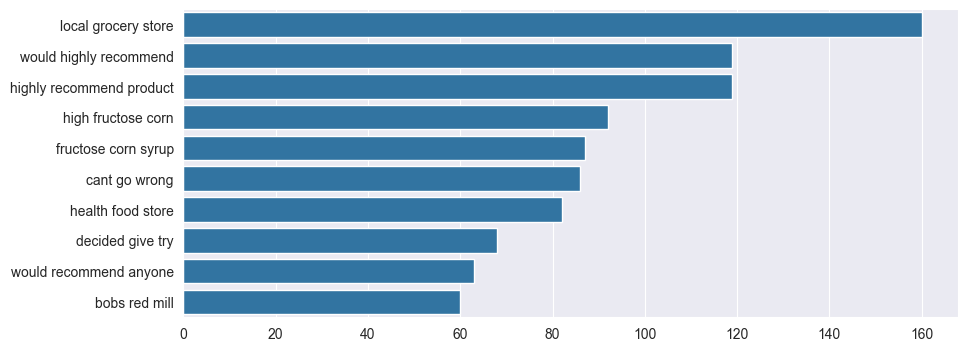

In [68]:
plt.figure(figsize = (10,4))
most_common_tri = get_top_text_ngrams(df.text,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))
plt.show()

In [69]:
# Importing required libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score

In [70]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

In [71]:
word_index = tokenizer.word_index

In [72]:
max_len = [len(x) for x in sequences]
max_len = max(max_len)
max_len

744

In [73]:
X_padded = pad_sequences(sequences, maxlen=max_len, padding='pre')

In [76]:
df.Score = df.Score.map(lambda x: int(x-1))

In [77]:
df.Score.value_counts()

Score
4    19277
3     4178
0     2689
2     2295
1     1561
Name: count, dtype: int64

In [78]:
df.columns

Index(['Score', 'text'], dtype='object')

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, df['Score'], test_size=0.3, random_state=42)

In [80]:
import gensim.downloader as api
word2vec = api.load('word2vec-google-news-300')

In [81]:
# Create an embedding matrix for the word2vec model
embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word2vec:
        embedding_matrix[i] = word2vec[word]

## Implementing Simple RNN

In [82]:
# Build the RNN Model
model = Sequential()
model.add(Embedding(input_dim=len(word_index)+1, output_dim=embedding_dim, weights=[embedding_matrix], input_length = max_len, trainable = False))
model.add(SimpleRNN(128, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(5, activation='sigmoid'))
model.build(input_shape=(None, len(word_index)+1))

c:\Users\Anubhav Prasad\anaconda3\envs\py39\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [83]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 53035, 300)     │    15,910,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 128)            │        54,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,966,057 (60.91 MB)

 Trainable params: 55,557 (217.02 KB)

 Non-trainable params: 15,910,500 (60.69 MB)

In [84]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [87]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 55s 169ms/step - accuracy: 0.6810 - loss: 0.8764 - val_accuracy: 0.6673 - val_loss: 0.9380
Epoch 2/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 54s 164ms/step - accuracy: 0.6927 - loss: 0.8463 - val_accuracy: 0.6603 - val_loss: 0.9512
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 53s 163ms/step - accuracy: 0.7056 - loss: 0.8127 - val_accuracy: 0.6522 - val_loss: 0.9423
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 53s 162ms/step - accuracy: 0.6798 - loss: 0.9033 - val_accuracy: 0.6507 - val_loss: 1.0263
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 57s 173ms/step - accuracy: 0.6542 - loss: 0.9749 - val_accuracy: 0.6441 - val_loss: 1.1762
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 70s 213ms/step - accuracy: 0.6435 - loss: 1.0370 - val_accuracy: 0.6437 - val_loss: 1.1236
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 52s 159ms/step - accuracy: 0.5729 - loss: 1.2818 - val_accuracy: 0.6437 - val_loss: 1.1056
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 53s 162ms/step - accuracy: 0.6399 - loss: 1

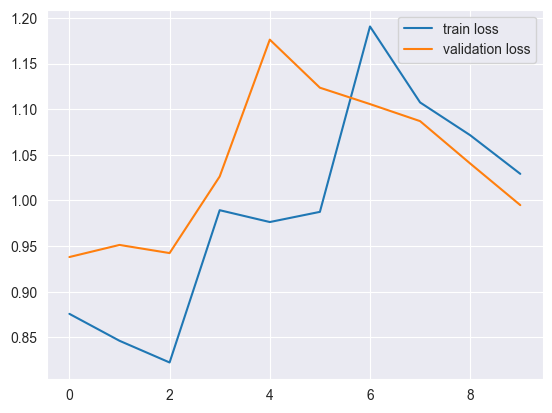

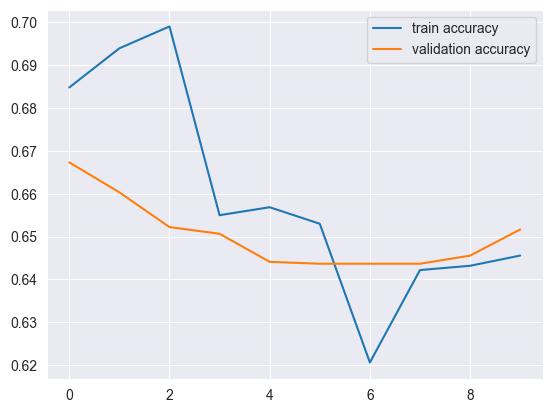

In [92]:
h = history

# plot the loss value
plt.plot(h.history['loss'], label='train loss')
plt.plot(h.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

# plot the accuracy value
plt.plot(h.history['accuracy'], label='train accuracy')
plt.plot(h.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

## Implementing LSTM

In [88]:
from tensorflow.keras.layers import LSTM

# Build the Deep RNN Model
model = Sequential()
model.add(Embedding(input_dim=len(word_index)+1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(5, activation='sigmoid'))
model.build(input_shape=(None, max_len))
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 744, 300)       │    15,910,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 744, 128)       │       219,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,262,377 (62.04 MB)

 Trainable params: 351,877 (1.34 MB)

 Non-trainable params: 15,910,500 (60.69 MB)

In [89]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [93]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 686s 2s/step - accuracy: 0.6543 - loss: 1.0148 - val_accuracy: 0.6749 - val_loss: 0.9253
Epoch 2/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 1251s 4s/step - accuracy: 0.6756 - loss: 0.9010 - val_accuracy: 0.6869 - val_loss: 0.8682
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 3109s 9s/step - accuracy: 0.6933 - loss: 0.8434 - val_accuracy: 0.6910 - val_loss: 0.8475
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 858s 3s/step - accuracy: 0.6977 - loss: 0.8222 - val_accuracy: 0.6937 - val_loss: 0.8491
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 1804s 5s/step - accuracy: 0.7201 - loss: 0.7678 - val_accuracy: 0.6947 - val_loss: 0.8602
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 1385s 4s/step - accuracy: 0.7203 - loss: 0.7570 - val_accuracy: 0.6979 - val_loss: 0.8344
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 789s 2s/step - accuracy: 0.7392 - loss: 0.7054 - val_accuracy: 0.6987 - val_loss: 0.8546
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 806s 2s/step - accuracy: 0.7467 - loss: 0.6809 - val_

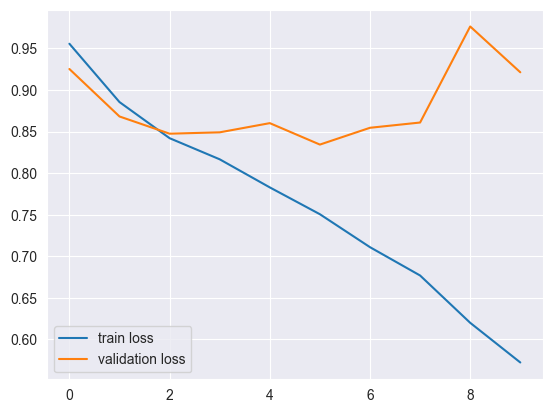

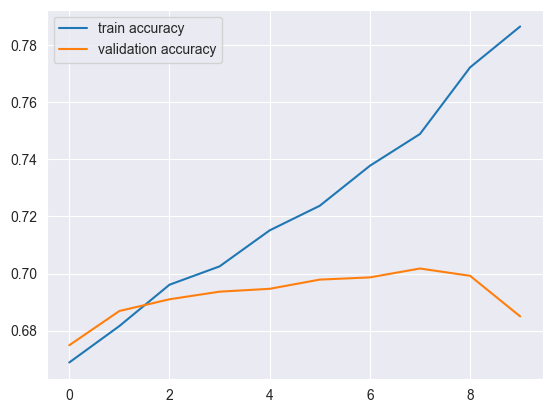

In [94]:
h = history

# plot the loss value
plt.plot(h.history['loss'], label='train loss')
plt.plot(h.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

# plot the accuracy value
plt.plot(h.history['accuracy'], label='train accuracy')
plt.plot(h.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()